# Execution visualization

In [1]:
# Required packages
import pandas as pd
import numpy as np
from IPython.display import HTML
import seaborn as sns
from scipy.spatial.distance import pdist

# Matplotlib
import matplotlib
from matplotlib import animation, cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

matplotlib.rcParams['animation.embed_limit'] = 2**128

## Functions

In [2]:
def join_runs(dfs, add_initial=False, add_initial_time=27.5):
    f_data = pd.concat(dfs, ignore_index=True)
    f_data_grouped = f_data.groupby('Iteration')[['SminaDock fitness', 'Time']].agg(
        {
            'SminaDock fitness': ['mean', 'min', 'max', 'std'],
            'Time': ['mean', 'min', 'max']
        }
    ).reset_index()
    if add_initial:
        f_data_grouped.loc[f_data_grouped.index[0], 'Time'] = add_initial_time
    f_data_grouped['Time'] = f_data_grouped['Time'].cumsum()
    return f_data_grouped

def get_fitness(df):
    df[df.columns[-1]] = df[df.columns[-1]].apply(lambda x: x[0])
    return df

In [3]:
def compare_fitness_evolution(dataframes, labels, baseline=False, baseline_value=None, time_cut=100, show_std=True, std=0.5):
    """
    Compare the evolution of SminaDock fitness over time for multiple executions.

    Parameters:
    - dataframes: list of pandas DataFrames
    - labels: list of strings, labels corresponding to each DataFrame
    """
    if len(dataframes) != len(labels):
        raise ValueError("The number of dataframes must match the number of labels.")
    
    plt.figure(figsize=(12, 6))
    
    if baseline:
        plt.axhline(y=baseline_value, color='black', linestyle='--', label='Baseline')

    colors = plt.colormaps.get_cmap('tab10')

    for i, (df, label) in enumerate(zip(dataframes, labels)):
        df = df[df['Time']['mean'] <= time_cut]        
        
        # Print metrics
        last = df[df['Iteration'] == df['Iteration'].max()]['SminaDock fitness']
        
        print(f"Execution {label} - Minimum loss: {round(last['min'].values[0], 2)}, "
              f"Maximum loss: {round(last['max'].values[0], 2)}, "
              f"Mean loss: {round(last['mean'].values[0], 2)}, "
              f"Std Dev: {round(last['std'].values[0], 2)}",
              f"Total iterations: {df['Iteration'].max()}")

        # Plot mean
        plt.plot(df['Time']['mean'], df['SminaDock fitness']['mean'], label=label, color = colors(i % colors.N))

        # Plot std deviation area
        if show_std:
            plt.fill_between(df['Time']['mean'],
                             df['SminaDock fitness']['mean'] - df['SminaDock fitness']['std'] * std,
                             df['SminaDock fitness']['mean'] + df['SminaDock fitness']['std'] * std,
                             color=colors(i), alpha=0.2, label=f'{label} ±{std} Std Dev')

    plt.title('Evolution of Smina over time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:
def alleles_analysis(data_input):
    '''
    Plot the evolution of the values of the alleles within the population
    '''
    data = data_input.copy()
    # Expand the Allele column
    data = data.drop(columns='Allele').join(data['Allele'].apply(pd.Series))
    data_expanded = data.explode('float')
    data_expanded['float'] = pd.to_numeric(data_expanded['float'])
    data_expanded = data_expanded.dropna(subset=['float']) # Drop NaN
    data_expanded['float_index'] = data_expanded.groupby(['ID', 'Iteration']).cumcount()

    # Pivot for plotting
    pivot_data = data_expanded.pivot_table(index='float_index', columns='Iteration', values='float', aggfunc='mean').sort_index()
    pivot_data = pivot_data.dropna()
        
    # Get the first and last recorded values for each Allele Index
    first_iteration_values = pivot_data[pivot_data.columns[0]]
    final_iteration_values = pivot_data[pivot_data.columns[-1]]   
    scale_factor = 2  # Adjust this to control separation
    allele_indices = first_iteration_values.index * scale_factor
    
    # Plot lines connecting initial and final values
    plt.figure(figsize=(14, 6))
    for idx, x in zip(first_iteration_values.index, allele_indices):
        plt.plot([x, x], [first_iteration_values[idx], final_iteration_values[idx]], color='gray', linestyle='--', alpha=0.5)   
    # Initial iteration
    plt.scatter(
        allele_indices, first_iteration_values, 
        color='green', s=50, label="Initial Iteration", edgecolors='black'
    )    
    # Final iteration
    plt.scatter(
        allele_indices, final_iteration_values, 
        color='red', s=50, label="Final Iteration", edgecolors='black'
    )
    
    plt.xlabel("Allele Index", fontsize=12)
    plt.ylabel("Allele Value", fontsize=12)
    plt.title("Allele Value Distribution Over Iterations", fontsize=14)  
    plt.xticks(ticks=allele_indices[::2], labels=first_iteration_values.index[::2], rotation=90, fontsize=10)
    plt.gca().set_xticks(allele_indices[::2])
    plt.gca().tick_params(axis='x', which='both', length=5, width=1)    
    plt.legend()
    plt.show()

In [5]:
def euler_angles_to_direction(alpha, beta, gamma):
    """
    Converts Euler angles (in radians) to a direction vector.
    Uses intrinsic ZYX rotation (Rz * Ry * Rx).
    """
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(alpha), -np.sin(alpha)],
        [0, np.sin(alpha), np.cos(alpha)]
    ])

    R_y = np.array([
        [np.cos(beta), 0, np.sin(beta)],
        [0, 1, 0],
        [-np.sin(beta), 0, np.cos(beta)]
    ])

    R_z = np.array([
        [np.cos(gamma), -np.sin(gamma), 0],
        [np.sin(gamma), np.cos(gamma), 0],
        [0, 0, 1]
    ])

    R = R_z @ R_y @ R_x
    direction = R @ np.array([1, 0, 0])  # Rotate unit x-axis
    return direction


def animate_molecular_binding(data_input: pd.DataFrame, binding_site, save=False, save_path="output/evolution_animation.mp4"):
    data = data_input.copy()
    data = data[:100]
    data['Allele'] = data['Allele'].apply(lambda x: x['float'])

    # Extract coordinates and rotation
    data[['x', 'y', 'z']] = data['Allele'].apply(lambda allele: pd.Series([allele[0], allele[1], allele[2]]))
    data[['alpha', 'beta', 'gamma']] = data['Allele'].apply(lambda allele: pd.Series([allele[3], allele[4], allele[5]]))

    # Distance and color
    data['distance'] = data[['x', 'y', 'z']].apply(lambda row: np.linalg.norm(row - binding_site), axis=1)
    min_d, max_d = data['distance'].agg(['min', 'max'])
    data['norm_dist'] = (data['distance'] - min_d) / (max_d - min_d)
    data['color'] = data['norm_dist'].map(lambda d: cm.viridis(1 - d))  # Closer = greener

    best_per_iter = data.loc[data.groupby('Iteration')['distance'].idxmax()].copy()
    best_per_iter.set_index('Iteration', inplace=True)
    iterations = sorted(data['Iteration'].unique())

    plot_range = data[['x', 'y', 'z']].abs().max().max() + 0.5
    sphere_radius = plot_range * 1

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set(xlim=[-plot_range, plot_range],
           ylim=[-plot_range, plot_range],
           zlim=[-plot_range, plot_range],
           title="Molecular Binding Simulation")

    # Plot protein sphere
    u, v = np.mgrid[0:2 * np.pi:40j, 0:np.pi:20j]
    x_sphere = sphere_radius * np.cos(u) * np.sin(v)
    y_sphere = sphere_radius * np.sin(u) * np.sin(v)
    z_sphere = sphere_radius * np.cos(v)
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.2, edgecolor='none')

    # Initial data
    init_data = data[data['Iteration'] == 0]

    # Arrows
    arrows = []
    arrow_scale = 2  # Adjust length as needed
    for _, row in init_data.iterrows():
        direction = euler_angles_to_direction(row['alpha'], row['beta'], row['gamma']) * arrow_scale
        arrow = ax.quiver(row['x'], row['y'], row['z'], direction[0], direction[1], direction[2],
                          color=row['color'])
        arrows.append(arrow)

    # Best individual marker
    best_init = best_per_iter.loc[0]
    highlight, = ax.plot([best_init['x']], [best_init['y']], [best_init['z']],
                         'o', color='green', markersize=8, label='Best individual')

    # Legend and colorbar
    plt.legend()
    norm = Normalize(vmin=min_d, vmax=max_d)
    sm = ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1, shrink=0.6)
    cbar.set_label('Distance to Binding Site')

    def update(frame):
        iter_data = data[data['Iteration'] == frame]
        ax.set_title(f"Iteration {frame}")

        # Remove old arrows
        while arrows:
            arrow = arrows.pop()
            arrow.remove()

        # Plot new arrows
        for _, row in iter_data.iterrows():
            direction = euler_angles_to_direction(row['alpha'], row['beta'], row['gamma']) * arrow_scale
            arrow = ax.quiver(row['x'], row['y'], row['z'], direction[0], direction[1], direction[2],
                              color=row['color'])
            arrows.append(arrow)

        # Update best individual
        best = best_per_iter.loc[frame]
        highlight.set_data([best['x']], [best['y']])
        highlight.set_3d_properties([best['z']])

        return arrows + [highlight]

    ani = animation.FuncAnimation(fig, update, frames=iterations, interval=500, blit=False)

    if save:
        ani.save(save_path, writer="ffmpeg", fps=2)
        print(f"Animation saved to {save_path}")
    else:
        plt.close(fig)
        return HTML(ani.to_jshtml())

## Load data

In [6]:
# Normal runs
normal_1 = get_fitness(pd.read_parquet('normal/normal_50_v1.parquet'))
normal_2 = get_fitness(pd.read_parquet('normal/normal_50_v2.parquet'))
normal_3 = get_fitness(pd.read_parquet('normal/normal_50_v3.parquet'))
normal = join_runs([normal_1, normal_2, normal_3])

In [7]:
# Multi-parent crossover runs
mp_1 = get_fitness(pd.read_parquet('multi-parent/mp_50_v1.parquet'))
mp_2 = get_fitness(pd.read_parquet('multi-parent/mp_50_v2.parquet'))
mp_3 = get_fitness(pd.read_parquet('multi-parent/mp_50_v3.parquet'))
mp = join_runs([mp_1, mp_2, mp_3])

In [8]:
# Other runs
other_1 = get_fitness(pd.read_parquet('other_problems/1hvy/normal_10_v1.parquet'))
other_2 = get_fitness(pd.read_parquet('other_problems/1hvy/normal_10_v2.parquet'))
other_3 = get_fitness(pd.read_parquet('other_problems/1hvy/normal_10_v3.parquet'))
other = join_runs([other_1, other_2, other_3])

omp_1 = get_fitness(pd.read_parquet('other_problems/1hvy/mp_10_v1.parquet'))
omp_2 = get_fitness(pd.read_parquet('other_problems/1hvy/mp_10_v2.parquet'))
omp_3 = get_fitness(pd.read_parquet('other_problems/1hvy/mp_10_v3.parquet'))
omp = join_runs([omp_1, omp_2, omp_3])

## Diversity

In [9]:
def check_diversity(df, iteration=100):
    data = df[df['Iteration'] == iteration].copy()
    data['Allele'] = data['Allele'].apply(lambda x: x['float'])

    return np.stack(data['Allele'].values)

In [10]:
def average_euclidean_distance(population):
    return np.mean(pdist(population, metric='euclidean'))

def population_variance(population):
    return np.var(population, axis=0).mean()

In [11]:
def population_solutions(df_list, iteration):
    solutions = 0
    for df in df_list:
        df = df[df['Iteration'] == iteration]['SminaDock fitness']
        solutions += len(df[df < 0])
    
    return solutions

population_solutions([normal_1, normal_2, normal_3], iteration=423)

45

## Execution Visualization

Execution Normal - Minimum loss: -6.4, Maximum loss: 325.27, Mean loss: 132.4, Std Dev: 109.66 Total iterations: 423
Execution Multi-Parent - Minimum loss: -5.84, Maximum loss: 78.06, Mean loss: 1.07, Std Dev: 11.76 Total iterations: 16


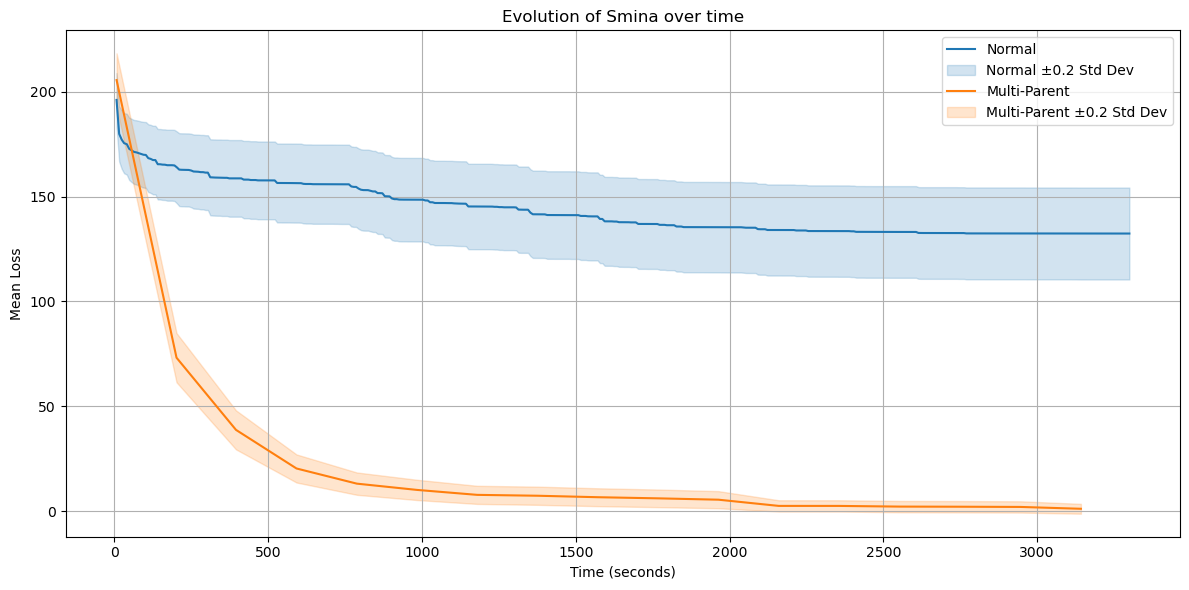

In [12]:
compare_fitness_evolution([normal, mp], ['Normal', 'Multi-Parent'], time_cut=3300, show_std=True, std=0.2)

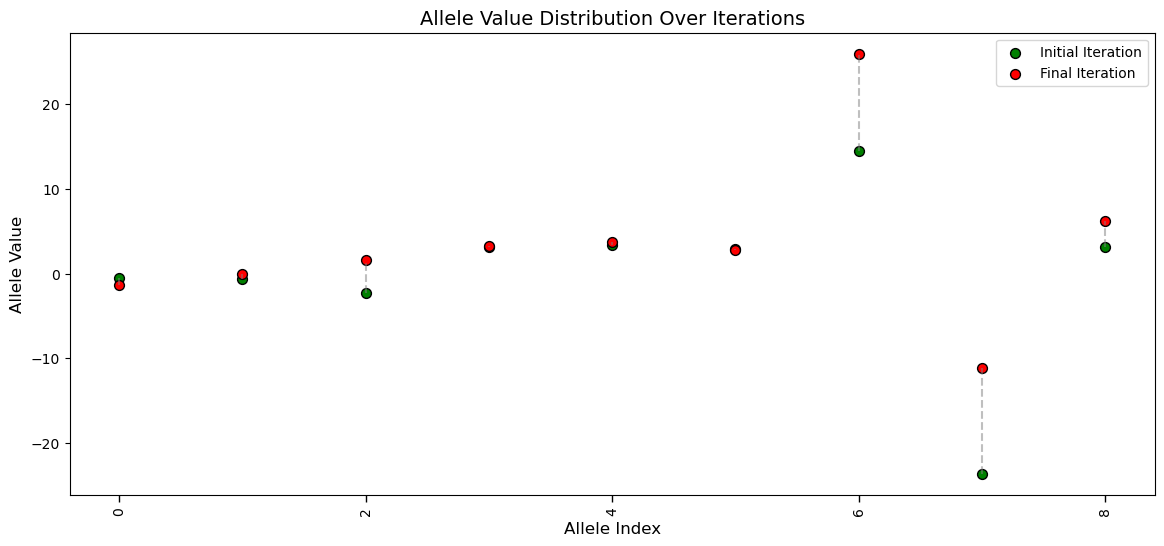

In [13]:
alleles_analysis(normal_1)

In [14]:
binding_sites = {
    '1g9v': [17.014, 16.306, 41.769],
    '1gm8': [14.630, -2.039, 4.016],
    '1gpk': [3.143, 67.222, 63.485],
    '1hnn': [28.600, 44.092, 17.173],
    '1hvy': [68.827, 45.122, 25.283]
}


# Call function to get animation HTML and display it inline
normal_1 = normal_1[:100] # Beware of creating big animations, size can explode
animation_html = animate_molecular_binding(normal_1, binding_site=binding_sites['1gpk'])

# Show animation
display(animation_html)